In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import os

os.chdir("/Users/amkagan/Desktop/gltm_experiments")

from collections import Counter

from itertools import product, chain
from InfluenceDiffusion.Graph import Graph
import cpnet

## Open log and network data

In [2]:
# simplify_graph("datasets/flixster_data/links.txt", "datasets/preprocessed_flixster/")
# make_action_log("datasets/flixster_data/Ratings.timed.txt", "datasets/preprocessed_flixster/")

In [3]:
action_df = pd.read_csv("flixster_data/preprocessed_flixster/action_logs.txt", header=None, sep=" ")
action_df = action_df.rename(columns={0: "user", 1: "action", 2: "time", 3: "raiting"})
action_df.head()

,user,action,time,raiting
0,6413,1,1247720400,5
1,17457,1,1246078800,2
2,22324,1,1246424400,4
3,26245,1,1245906000,3
4,58055,1,1246251600,5


In [4]:
# time is counted in minutes starting from 1 Jan 1970

action_year = 1970 + action_df["time"] // (60 * 60 * 24 * 365)
print("Pairs (year, num raitings this year): ")
print(sorted(Counter(action_year).items(), key=lambda kv: kv[0]))

Pairs (year, num raitings this year): 
[(2001, 2), (2005, 459), (2006, 849915), (2007, 3710445), (2008, 1906165), (2009, 1729079)]


In [5]:
# Flixster was launched in 2006, so the first year should be 36! Ratings made before 2006 seem 
# to be sanity check ones. We drop them.

action_df = action_df[action_year >= 2006]
action_year = action_year[action_year >= 2006]

In [6]:
edge_df = pd.read_csv("flixster_data/preprocessed_flixster/graph_undirected.txt", sep=" ", header=None)[[0,1]]
edge_df = edge_df.rename(columns={0: "from", 1: "to"})

In [7]:
print("Num nodes:", len(set(edge_df["from"]) | set(edge_df["to"])))
print("Num edges:", len(edge_df))

Num nodes: 786936
Num edges: 5897324


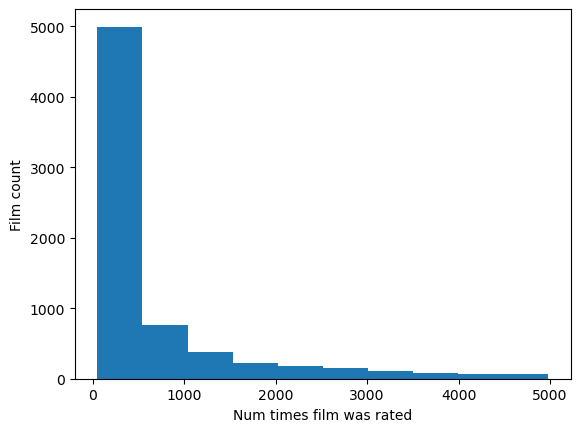

In [8]:
action_nums_dict = Counter(action_df["action"])

popular_actions = {action for action, num in action_nums_dict.items() if 5000 > num > 50}
len(popular_actions) / len(action_nums_dict)

plt.hist([action_nums_dict[action] for action in popular_actions])
plt.xlabel("Num times film was rated")
plt.ylabel("Film count")
plt.show()

In [9]:
popular_action_df = action_df[action_df["action"].apply(lambda x: x in popular_actions)]

In [10]:
user_num_actions = popular_action_df.groupby("user")["action"].nunique()

Text(0.5, 0, 'Num actions performed')

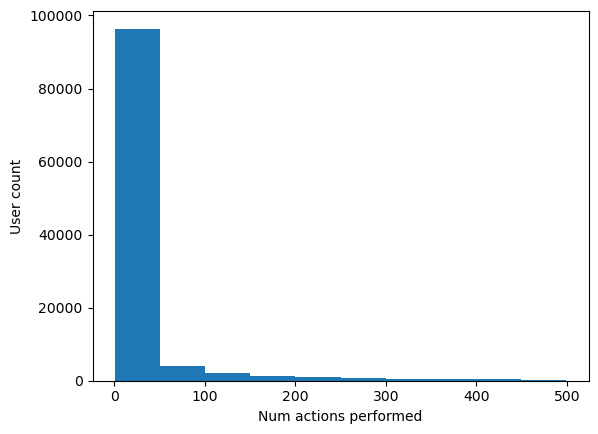

In [20]:
plt.hist(user_num_actions[(user_num_actions < 500)].values)
plt.ylabel("User count")
plt.xlabel("Num actions performed")

In [21]:
active_users = set(user_num_actions.index[(user_num_actions > 20) & (user_num_actions < 500)])
len(active_users) / len(user_num_actions), len(active_users)

(0.17639620653319282, 19251)

In [22]:
edge_mask = edge_df.apply(lambda edge: set(edge).issubset(active_users), axis=1)
active_edge_df = edge_df[edge_mask]
active_users_graph_nx = nx.Graph(active_edge_df.values.tolist())

In [23]:
# Delete periphery
algorithm = cpnet.KM_config()
algorithm.detect(active_users_graph_nx)
core_nodes = [node for node, if_core in algorithm.get_coreness().items() if if_core == 1]
active_users_graph_nx = active_users_graph_nx.subgraph(core_nodes)

print(len(core_nodes), "are in the core")

/home/amkagan/.local/lib/python3.10/site-packages/cpnet/utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


8962 are in the core


In [29]:
# Extract connected component 
big_comp = max(nx.connected_components(active_users_graph_nx), key=len)
print("Largest connected component:", len(big_comp))
active_users_graph_nx = active_users_graph_nx.subgraph(big_comp)

Largest connected component: 8174


In [30]:
print("Num nodes in the core of the subgraph:", len(big_comp))
print("Num edges in the core of the subgraph:", len(active_users_graph_nx.edges))
print("Core is connected:", nx.is_connected(active_users_graph_nx))

pd.DataFrame(active_users_graph_nx.edges).to_csv("flixster_data/connected_comp_action_trunc_edge_df_new.csv", 
                                                 index=None)

Num nodes in the core of the subgraph: 8174
Num edges in the core of the subgraph: 50515
Core is connected: True


In [31]:
trunc_popular_action_df = popular_action_df[popular_action_df["user"].apply(lambda user: user in 
                                                                            active_users_graph_nx.nodes)]
trunc_popular_action_df.to_csv("flixster_data/trunc_popular_action_df_new.csv", index=None)

In [32]:
print(f"Overall, {trunc_popular_action_df['action'].nunique()} actions")

Overall, 7041 actions


Avg degree of extracted graph 12.359921702960607


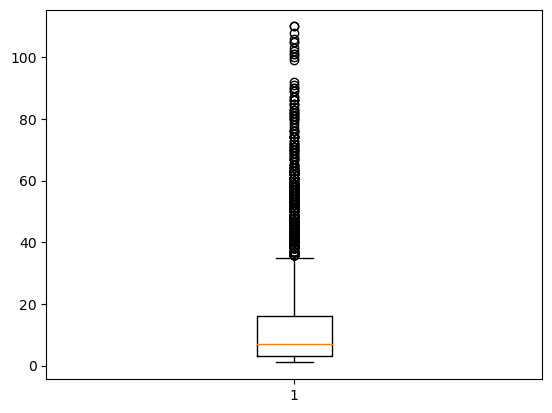

In [28]:
print("Avg degree of extracted graph", 2 * len(active_users_graph_nx.edges) / len(active_users_graph_nx.nodes))
plt.boxplot(dict(active_users_graph_nx.degree).values())
plt.show()